In [67]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVCal, UVFlag, utils
from glob import glob
from astropy import units as u
from astropy import constants as c
from astropy.time import Time
from astropy.coordinates import get_body, SkyCoord, AltAz, EarthLocation, Angle
from copy import deepcopy

In [5]:
calpath = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/RawData/'
rawpath = '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/'

In [6]:
uvd = UVData()
uvc = UVCal()

In [16]:
JD = '2457548'
juldate = JD+'.46619'
preamble = JD+'/zen.'+juldate

# The order in which the polarizations are read ... seems to matter.  This can probably be
# fixed, but this order avoids generating an error
datafile = rawpath+preamble+'.uvcRP.uvh5'
calfits = calpath+preamble + '.HH.uvcRP.calfits'

In [19]:
calfits

'/lustre/aoc/projects/hera/plaplant/HERA19Golden/RawData/2457548/zen.2457548.46619.HH.uvcRP.calfits'

In [20]:
ls /lustre/aoc/projects/hera/plaplant/HERA19Golden/RawData/2457548/zen.2457548.46619.HH.uvcRP.calfits

/lustre/aoc/projects/hera/plaplant/HERA19Golden/RawData/2457548/zen.2457548.46619.HH.uvcRP.calfits


In [24]:
uvd.read(datafile)
uvc.read_calfits(calfits)
# For reasons known but to Adam Beardsley, copy_flags is not by default True
uvf = UVFlag(uvd, mode='flag', copy_flags=True, run_check=True)

In [25]:
# Check that we have, indeed, the same flags
np.array_equal(uvd.flag_array, uvf.flag_array)

True

In [26]:
# I'm making 3 copies because the waterfall methods don't seem to have an
# inplace=False option ...
uvf_thresh = deepcopy(uvf)
uvf_or = deepcopy(uvf)
uvf_greedy = deepcopy(uvf)

In [27]:
# per-antenna flagging is yet another thing ...
# It looks like the calfits files already got the memo on antenna flagging ... 
# and the band edges ...
uvf_ant = UVFlag(uvc, mode='flag', copy_flags=True)
for i, ant in enumerate(uvf_ant.ant_array):
    print('{:03} {:.5f} {:.5f}'.format(ant, uvf_ant.flag_array[i,0,:,:,0].mean(), 
                                    uvf_ant.flag_array[i,0,:,:,1].mean()))

009 0.28516 0.28516
010 0.28516 0.28516
020 0.28516 0.28516
022 1.00000 1.00000
031 0.28516 0.28516
043 1.00000 1.00000
053 0.28516 0.28516
064 0.28516 0.28516
065 0.28516 0.28516
072 0.28516 0.28516
080 1.00000 1.00000
081 1.00000 1.00000
088 0.28516 0.28516
089 0.28516 0.28516
096 0.28516 0.28516
097 0.28516 0.28516
104 0.28516 0.28516
105 0.28516 0.28516
112 0.28516 0.28516


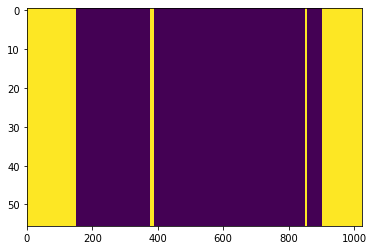

In [28]:
plt.imshow(np.array(uvf_ant.flag_array[0,0,:,:,0].T,dtype='float64'), aspect='auto')

In [29]:
uvf_ant.flag_array.shape

(19, 1, 1024, 56, 2)

In [30]:
ant_flags = uvf_ant.flag_array[0,0,:,0,0]
print(uvf_ant.freq_array.squeeze()[np.where(ant_flags == False)[0][0]]/1e6)
print(np.flip(uvf_ant.freq_array.squeeze())[np.where(np.flip(ant_flags) == False)[0][0]]/1e6)

114.6484375
187.890625


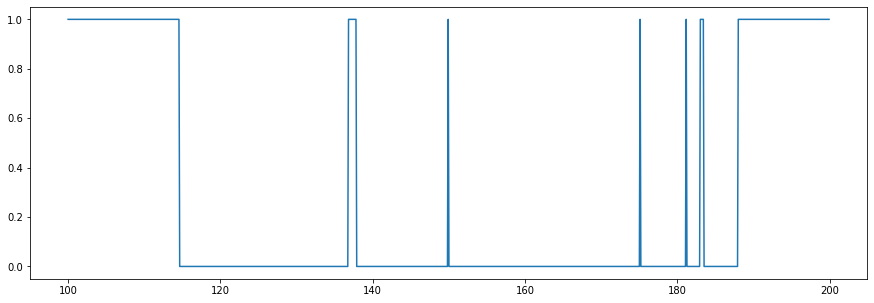

In [31]:
plt.figure(figsize=(15,5))
plt.plot(uvf_ant.freq_array.squeeze()/1e6,np.array(uvf_ant.flag_array[0,0,:,0,0],dtype='float64'))
#plt.plot(np.array(uvf_ant.flag_array[0,0,:,:,0].max(axis=1),dtype='float64'))
plt.show()

In [30]:
# Check for whether all the data are flagged and whether the sun is up

In [32]:
def flag_fraction(uvf):
    numflags = uvf.flag_array.sum()
    numdata = np.array(uvf.flag_array.shape).prod()
    if (numflags == numdata):
        print('All are flagged')
    else:
        print('{:.2f}% are flagged'.format(numflags/numdata*100.))

In [33]:
flag_fraction(uvf_or)

3.86% are flagged


In [34]:
# Unless you collapse along polarizations, the waterfalls are not all equal
uvf_or.to_waterfall(method='or', keep_pol=False)

In [35]:
uvf_or.flag_array.shape

(56, 1024, 1)

In [36]:
flag_fraction(uvf_or)

20.91% are flagged


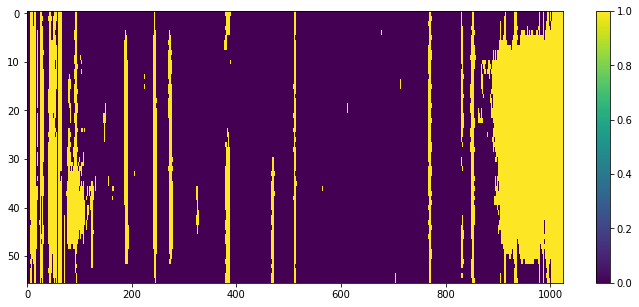

In [39]:
# What does this look like?
plt.figure(figsize=(12,5))
plt.imshow(np.array(uvf_or.flag_array.squeeze(),dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

In [45]:
uvf_or.to_baseline(uvd, force_pol=True)

In [46]:
uvf_or.flag_array.shape

(10640, 1, 1024, 4)

In [47]:
# Write it out
uvf_or.write('flag.'+juldate+'.or.uvh5', clobber=True)

File flag.2457548.46619.or.uvh5 exists; clobbering


In [51]:
# This converts the flag array to a metric array using the mean
uvf_thresh.to_waterfall(method='mean', keep_pol=False)

This object is already a waterfall. Nothing to change.


In [54]:
uvf_thresh.metric_array.shape

(56, 1024, 1)

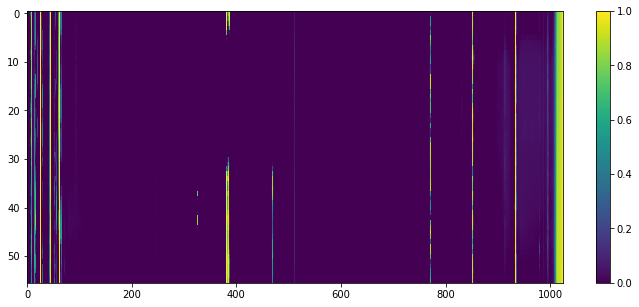

In [55]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(uvf_thresh.metric_array.squeeze(),dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

In [57]:
# to convert this back to a flag array
uvf_thresh.to_flag(threshold=0.2)

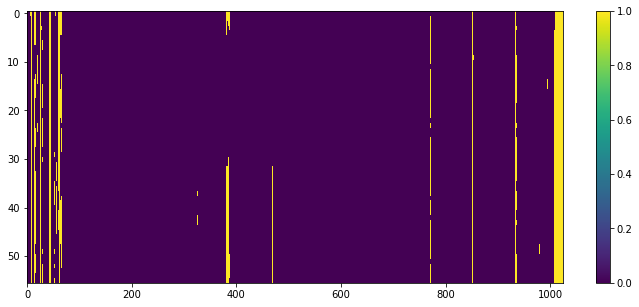

In [58]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(uvf_thresh.flag_array.squeeze(),dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

In [59]:
print(uvf_thresh.flag_array.shape)
uvf_thresh.to_baseline(uvd, force_pol=True)
print(uvf_thresh.flag_array.shape)
uvf_thresh.write('flag.'+juldate+'.thresh.uvh5', clobber=True)

(56, 1024, 1)
(10640, 1, 1024, 4)


In [64]:
# The other kind of flagging I was thinking is if > N% of frequencies are flagged at some time,
# then all frequencies are flagged, and similarly for times flagged at some frequency
# We have to implement this manually

In [76]:
uvf_greedy.to_waterfall(method='or', keep_pol=False)
print(uvf_greedy.flag_array.shape)
print(uvf_greedy.flag_array.dtype)

(56, 1024, 1)
bool


This object is already a waterfall. Nothing to change.


In [86]:
time_frac = uvf_greedy.flag_array.mean(axis=1).squeeze()
freq_frac = uvf_greedy.flag_array.mean(axis=0).squeeze()

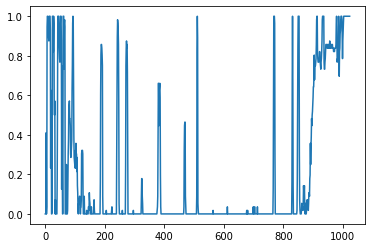

In [87]:
plt.plot(freq_frac)

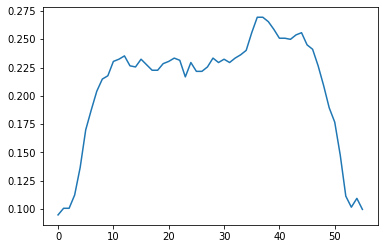

In [88]:
plt.plot(time_frac)

In [89]:
uvf_greedy.flag_array.shape

(56, 1024, 1)

In [90]:
time_frac.shape

(56,)

In [94]:
uvf_greedy.flag_array[time_frac>0.33,:,0] = True
uvf_greedy.flag_array[:,freq_frac>0.10,0] = True

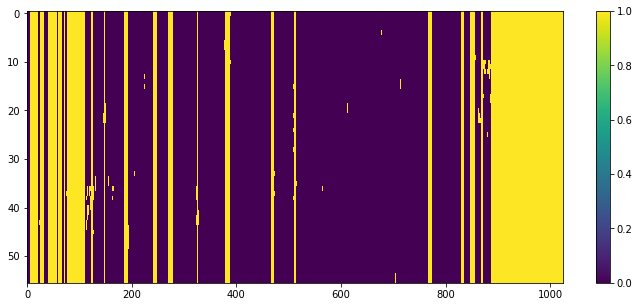

In [95]:
plt.figure(figsize=(12,5))
plt.imshow(np.array(uvf_greedy.flag_array.squeeze(),dtype='float64'), aspect='auto')
plt.colorbar()
plt.show()

In [70]:
# We can apply the flags to data using
utils.apply_uvflag(uvd, uvf_or)
# by default, this "OR"s with existing flags

In [72]:
# and the resulting uvd can be written out